# Intro. to Snorkel: Extracting Spouse Relations from the News

In this tutorial, we will walk through the process of using `Snorkel` to identify mentions of spouses in a corpus of news articles. The tutorial is broken up into 3 notebooks, each covering a step in the pipeline:
1. Preprocessing
2. Training
3. Evaluation

## Part I: Preprocessing

In this notebook, we preprocess several documents using `Snorkel` utilities, parsing them into a simple hierarchy of component parts of our input data, which we refer to as _contexts_. We'll also create _candidates_ out of these contexts, which are the objects we want to classify, in this case, possible mentions of spouses. Finally, we'll load some gold labels for evaluation.

All of this preprocessed input data is saved to a database.  (Connection strings can be specified by setting the `SNORKELDB` environment variable.  In Snorkel, if no database is specified, then a SQLite database at `./snorkel.db` is created by default--so no setup is needed here!

### Initializing a `SnorkelSession`

First, we initialize a `SnorkelSession`, which manages a connection to a database automatically for us, and will enable us to save intermediate results.  If we don't specify any particular database (see commented-out code below), then it will automatically create a SQLite database in the background for us:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
os.environ['SNORKELDB'] = 'postgres://localhost/snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

# Here, we just set how many documents we'll process for automatic testing- you can safely ignore this!
n_docs = 500 if 'CI' in os.environ else 2591

## Loading the Corpus

Next, we load and pre-process the corpus of documents.

### Configuring a `DocPreprocessor`

We'll start by defining a `TSVDocPreprocessor` class to read in the documents, which are stored in a tab-seperated value format as pairs of document names and text.

In [2]:
from snorkel.parser import GDDDocPreprocessor

doc_preprocessor = GDDDocPreprocessor('data/sentences_nlp352', max_docs=n_docs)

### Running a `CorpusParser`

We'll use [Spacy](https://spacy.io/), an NLP preprocessing tool, to split our documents into sentences and tokens, and provide named entity annotations.

In [3]:
from snorkel.parser.gdd_parser import Gdd
from snorkel.parser import CorpusParser

corpus_parser = CorpusParser(parser=Gdd())
%time corpus_parser.apply(doc_preprocessor, count=n_docs)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 6min 1s, sys: 1min 45s, total: 7min 47s
Wall time: 17min 1s


We can then use simple database queries (written in the syntax of [SQLAlchemy](http://www.sqlalchemy.org/), which Snorkel uses) to check how many documents and sentences were parsed:

In [4]:
from snorkel.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

('Documents:', 475L)
('Sentences:', 280651L)


## Generating Candidates

The next step is to extract _candidates_ from our corpus. A `Candidate` in Snorkel is an object for which we want to make a prediction. In this case, the candidates are pairs of people mentioned in sentences, and our task is to predict which pairs are described as married in the associated text.

### Defining a `Candidate` schema
We now define the schema of the relation mention we want to extract (which is also the schema of the candidates).  This must be a subclass of `Candidate`, and we define it using a helper function. Here we'll define a binary _spouse relation mention_ which connects two `Span` objects of text.  Note that this function will create the table in the database backend if it does not exist:

In [5]:
from snorkel.models import candidate_subclass

Measurement = candidate_subclass('Measurement', ['strat_name', 'value'])

### Writing a basic `CandidateExtractor`

Next, we'll write a basic function to extract **candidate spouse relation mentions** from the corpus.  The [Spacy](https://spacy.io/) parser we used performs _named entity recognition_ for us.

We will extract `Candidate` objects of the `Spouse` type by identifying, for each `Sentence`, all pairs of n-grams (up to 7-grams) that were tagged as people. (An n-gram is a span of text made up of n tokens.) We do this with three objects:

* A `ContextSpace` defines the "space" of all candidates we even potentially consider; in this case we use the `Ngrams` subclass, and look for all n-grams up to 7 words long

* A `Matcher` heuristically filters the candidates we use.  In this case, we just use a pre-defined matcher which looks for all n-grams tagged by Spacy as "PERSON". The keyword argument `longest_match_only` means that we'll skip n-grams contained in other n-grams.

* A `CandidateExtractor` combines this all together!

In [6]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import DictionaryMatch, RegexMatchSpan

ngrams         = Ngrams(n_max=7)
#person_matcher = PersonMatcher(longest_match_only=True)
strat_names = []
with open("data/strat_names") as fin:
    for line in fin:
        strat_names.append(line.strip().replace('"', ''))
print strat_names[:5]
    
stratname_matcher = DictionaryMatch(d=strat_names)
measurement_matcher = RegexMatchSpan(rgx = '\d+(?:\.\d*)?(?: ?[+ \-±/Ϯ]+ *\d*(?:\.\d*)* ?)*[MG]a')
cand_extractor = CandidateExtractor(Measurement, [ngrams, ngrams], [stratname_matcher, measurement_matcher])

['Bajada Del Agrio Group', 'Bajo de La Carpa Formation', 'Candeleros Formation', 'Carrere Formation', 'Cerro Lisandro Formation']


Next, we'll split up the documents into train, development, and test splits; and collect the associated sentences.

Note that we'll filter out a few sentences that mention more than five people. These lists are unlikely to contain spouses.

In [7]:
from snorkel.models import Document
from sqlalchemy.sql.expression import func
docs = session.query(Document).order_by("reverse(name)")
# docs = session.query(Document).order_by(Document.name).all()

train_sents = set()
dev_sents   = set()
test_sents  = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
        if i % 10 == 9:
            dev_sents.add(s)
        elif i % 10 == 8:
            test_sents.add(s)
        else:
            train_sents.add(s)

/Users/iross/miniconda2/envs/py2Env/lib/python2.7/site-packages/sqlalchemy/sql/compiler.py:624: SAWarning: Can't resolve label reference 'reverse(name)'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


In [8]:
print "dev: ", len(dev_sents)
print "train: ", len(train_sents)
print "test: ", len(test_sents)
print "total: ", len(dev_sents) + len(test_sents) + len(train_sents)

dev:  28233
train:  220864
test:  31554
total:  280651


Finally, we'll apply the candidate extractor to the three sets of sentences. The results will be persisted in the database backend.

In [9]:
%%time
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
#for i, sents in enumerate([train_sents]):
    cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Measurement).filter(Measurement.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 611L)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 206L)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 23L)
CPU times: user 14min 2s, sys: 1min 54s, total: 15min 56s
Wall time: 1h 24min 21s


In [10]:
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer(session.query(Measurement).filter(Measurement.split == 1), session, height=500)
sv

<IPython.core.display.Javascript object>

Widget Javascript not detected.  It may not be installed or enabled properly.


In [36]:
from lib.init import *
from lib.scoring import *
from lib.lf_factories import *
from snorkel.lf_helpers import *
age_words = {'age', 'aged', 'dated', 'ages'}
uncertainty_words = {'uncertainty', 'uncertainties'}


LF_age_words = MatchTerms(name='age_words', terms=age_words, label=1, search='sentence').lf()

LF_uncertainty_words = MatchTerms(name='uncertainty_words', terms=uncertainty_words, label=-1, search='sentence').lf()


attributed_words = {'for', 'in'}
LF_attributed_words = MatchTerms(name='attributed', terms=attributed_words, label=1, search='between').lf()
LF_paren_between = MatchTerms(name='paren', terms={'-LRB-', '-RRB-'}, label=1, search='between').lf()

def LF_Ar_Ar_mentioned(c):
    text_splits = get_text_splits(c)
    for text in text_splits:
        if "40Ar/39Ar" in text: return 1
    else:
        return 0
    
def LF_Pb_Pb_mentioned(c):
    text_splits = get_text_splits(c)
    for text in text_splits:
        if "207Pb/206Pb" in text: return 1
    else:
        return 0
    


In [37]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='iross', split=1)

In [38]:
#coverage(session, LF_Ar_Ar_mentioned, split=0)
tp, fp, tn, fn = error_analysis(session, LF_age_words, split=1, gold=L_gold_dev)
#SentenceNgramViewer(fp, session, n_per_page=1)

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.474
Recall               1.0
F1                   0.643
----------------------------------------
TP: 18 | FP: 20 | TN: 0 | FN: 0



In [14]:
import requests
resp = requests.get("https://macrostrat.org/api/v2/defs/strat_names?all")
stratz = resp.json()["success"]["data"]

In [15]:
macrostrat_ages = set()
for strat in stratz:
    macrostrat_ages.add((strat['strat_name'], str(strat['b_age']) + " Ma"))
    macrostrat_ages.add((strat['strat_name'], str(strat['t_age']) + " Ma"))

In [16]:
macrostrat_ages

{(u'Bilinguites Superbilinguis Marine Band', '323.2 Ma'),
 (u'Top Durham Low Main Coal', '323.2 Ma'),
 (u'Opeche Shale', '270.2333 Ma'),
 (u'Blackmount', '25.2 Ma'),
 (u'Sty Head Tarn', '458.4 Ma'),
 (u'Fuson Shale', '125 Ma'),
 (u'Wooly Dolomite', '1800 Ma'),
 (u'Tumbez Limestone', '458.4 Ma'),
 (u'Oregon Limestone', '470 Ma'),
 (u'Seafield Tower Limestone', '323.2 Ma'),
 (u'Yaouk Leucogranite', '427.4 Ma'),
 (u'Belmore Granite', '443.8 Ma'),
 (u'Marshall Green Coal', '323.2 Ma'),
 (u'Capita Shale', '33.9 Ma'),
 (u'Jordanhill New Blackband Ironstone', '323.2 Ma'),
 (u'Jacque Mountain Limestone', '312 Ma'),
 (u'Maidenhead', '0.781 Ma'),
 (u'Bow Breccia', '252.17 Ma'),
 (u'Moira', 'None Ma'),
 (u'Burnt Meadow Complex', '174.1 Ma'),
 (u'Orocopia Schist', '90.825 Ma'),
 (u'Gunder', '0.0117 Ma'),
 (u'Sandwick Fish Bed', '393.3 Ma'),
 (u'Nunniong Granodiorite', '427.4 Ma'),
 (u'Horton Creek', '346.7 Ma'),
 (u'Broubster Till', '0.0117 Ma'),
 (u'Roxana Silt', '0.15 Ma'),
 (u'Farmington Sandst

In [39]:
LF_distant_supervision = DistantSupervision("macrostrat", kb=macrostrat_ages).lf()
labeled = coverage(session, LF_distant_supervision, split=1)

Coverage: 1.46% (3/206)


In [40]:
labeled = []
for c in session.query(Measurement).filter(Measurement.split == 1).all():
    if LF_Ar_Ar_mentioned(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))

('Number labeled:', 0)


In [41]:
LFs = [LF_age_words, LF_Ar_Ar_mentioned, LF_paren_between, LF_Pb_Pb_mentioned, LF_uncertainty_words, LF_distant_supervision]

## 2. Applying the Labeling Functions

Next, we need to actually run the LFs over all of our training candidates, producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database.  We'll do this using the `LabelAnnotator` class, a UDF which we will again run with `UDFRunner`.  **Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set.**  We start by setting up the class:

In [42]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

Finally, we run the `labeler`. Note that we set a random seed for reproducibility, since some of the LFs involve random number generators. Again, this can be run in parallel, given an appropriate database like Postgres is being used:

In [43]:
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 5.73 s, sys: 403 ms, total: 6.13 s
Wall time: 8.49 s


<611x6 sparse matrix of type '<type 'numpy.int64'>'
	with 643 stored elements in Compressed Sparse Row format>

If we've already created the labels (saved in the database), we can load them in as a sparse matrix here too:

In [44]:
L_train = labeler.load_matrix(session, split=0)
L_train

<611x6 sparse matrix of type '<type 'numpy.int64'>'
	with 643 stored elements in Compressed Sparse Row format>

Note that the returned matrix is a special subclass of the `scipy.sparse.csr_matrix` class, with some special features which we demonstrate below:

In [45]:
L_train.get_candidate(session, 0)

Measurement(Span("Warramunga Formation", sentence=575187, chars=[105,124], words=[18,19]), Span("1860 Ma", sentence=575187, chars=[89,95], words=[14,15]))

In [46]:
L_train.get_key(session, 0)

LabelKey (LF_TERMS_age_words_[sentence|words]_TRUE)

We can also view statistics about the resulting label matrix.

* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a *conflicting* non-zero label for.

In [47]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_TERMS_age_words_[sentence|words]_TRUE,0,0.338789,0.188216,0.003273
LF_Ar_Ar_mentioned,1,0.073650,0.073650,0.003273
LF_TERMS_paren_[between|words]_TRUE,2,0.631751,0.142390,0.001637
LF_Pb_Pb_mentioned,3,0.004910,0.004910,0.000000
LF_TERMS_uncertainty_words_[sentence|words]_FALSE,4,0.003273,0.003273,0.003273
LF_DIST_SUPERVISION_macrostrat_TRUE,5,0.000000,0.000000,0.000000


## 3. Fitting the Generative Model
Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [48]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [49]:
gen_model.weights.lf_accuracy

array([ 0.41471946,  0.14784156,  0.80976555,  0.0822947 ,  0.0712936 ,
        0.06498801])

We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [50]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

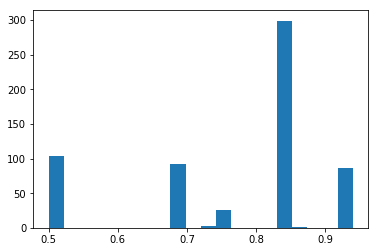

In [51]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

We can view the learned accuracy parameters, and other statistics about the LFs learned by the generative model:

In [52]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.692263,0.6811,0.700959,0.477908
1,0.571684,0.6724,0.574182,0.389538
2,0.829503,0.7267,0.828057,0.601149
3,0.538060,0.6700,0.541519,0.364375
4,0.539177,0.6662,0.538237,0.365366
5,0.531344,0.6668,0.527172,0.359421


### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set.  First, we apply the LFs to our development set:

In [53]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



And finally, we get the score of the generative model:

In [54]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.564
Neg. class accuracy: 0.563
Precision            0.232
Recall               0.564
F1                   0.328
----------------------------------------
TP: 22 | FP: 73 | TN: 94 | FN: 17



### Interpreting Generative Model Performance

At this point, we should be getting an F1 score of around 0.4 to 0.5 on the development set, which is pretty good!  However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!  

In fact, it is probably somewhat _overfit_ to this set. However this is fine, since in the next tutorial, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a _blind_ test set (i.e. one we never looked at during development).

### Doing Some Error Analysis

At this point, we might want to look at some examples in one of the error buckets. For example, one of the false negatives that we did not correctly label as true mentions.  To do this, we can again just use the `Viewer`:

In [33]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fn, session)
else:
    sv = None

<IPython.core.display.Javascript object>

In [34]:
sv

Widget Javascript not detected.  It may not be installed or enabled properly.


We can save the best model from the hyperparameter search with a custom name so that we can reload it later.

In [35]:
c = sv.get_selected() if sv else list(fp.union(fn))[0]
c

IndexError: list index out of range

We can easily see the labels that the LFs gave to this candidate using simple ORM-enabled syntax:

In [ ]:
c.labels

We can also now explore some of the additional functionalities of the `lf_stats` method for our dev set LF labels, `L_dev`: we can plug in the gold labels that we have, and the accuracies that our generative model has learned:

In [55]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

snorkel/annotations.py:129: RuntimeWarning: invalid value encountered in divide
  ac = (tp+tn).astype(float) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_TERMS_age_words_[sentence|words]_TRUE,0,0.184466,0.067961,0.0,18,20,0,0,0.473684,0.690666
LF_Ar_Ar_mentioned,1,0.000000,0.000000,0.0,0,0,0,0,NaN,0.571471
LF_TERMS_paren_[between|words]_TRUE,2,0.339806,0.077670,0.0,13,56,0,0,0.188406,0.835792
LF_Pb_Pb_mentioned,3,0.000000,0.000000,0.0,0,0,0,0,NaN,0.535848
LF_TERMS_uncertainty_words_[sentence|words]_FALSE,4,0.000000,0.000000,0.0,0,0,0,0,NaN,0.530226
LF_DIST_SUPERVISION_macrostrat_TRUE,5,0.014563,0.009709,0.0,0,3,0,0,0.000000,0.540153


Note that for labeling functions with low coverage, our learned accuracies are closer to our prior of 70% accuracy.

### Saving our training labels

Finally, we'll save the `training_marginals`, which are our **probabilistic training labels**, so that we can use them in the next tutorial to train our end extraction model:

In [56]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 611 marginals
CPU times: user 588 ms, sys: 56.3 ms, total: 644 ms
Wall time: 1.09 s


Next, in Part III, we'll use these probabilistic training labels to train a deep neural network.

In [ ]:
# ==================== END OF  PART 2 ======================

## Part III: Training an End Extraction Model

In this final section of the tutorial, we'll use the noisy training labels we generated in the last tutorial part to train our end extraction model.

For this tutorial, we will be training a Bi-LSTM, a state-of-the-art deep neural network implemented in [TensorFlow](https://www.tensorflow.org/).

In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

from snorkel import SnorkelSession
session = SnorkelSession()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We repeat our definition of the `Spouse` `Candidate` subclass:

In [66]:
from snorkel.annotations import load_marginals

train_marginals = load_marginals(session, split=0)

We also reload the candidates:

In [67]:
train_cands = session.query(Measurement).filter(Measurement.split == 0).order_by(Measurement.id).all()
dev_cands   = session.query(Measurement).filter(Measurement.split == 1).order_by(Measurement.id).all()
test_cands  = session.query(Measurement).filter(Measurement.split == 2).order_by(Measurement.id).all()

Finally, we load gold labels for evaluation:

In [95]:
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer(session.query(Measurement).filter(Measurement.split == 2), session, height=600)
sv

<IPython.core.display.Javascript object>

Widget Javascript not detected.  It may not be installed or enabled properly.


In [82]:
from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='iross', split=1)
L_gold_test = load_gold_labels(session, annotator_name='iross', split=2)

Now we can setup our discriminative model. Here we specify the model and learning hyperparameters.

They can also be set automatically using a search based on the dev set with a [GridSearch](https://github.com/HazyResearch/snorkel/blob/master/snorkel/learning/utils.py) object.

In [83]:
L_gold_dev

<206x1 sparse matrix of type '<type 'numpy.int64'>'
	with 201 stored elements in Compressed Sparse Row format>

In [87]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.01,
    'dim':        50,
    'n_epochs':   30,
    'dropout':    0.25,
    'print_freq': 1,
    'max_sentence_length': 100
}

lstm = reRNN(seed=1701, n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=507  #epochs=30  batch size=256
[reRNN] Epoch 0 (1.67s)	Average loss=0.667006	Dev F1=31.84
[reRNN] Epoch 1 (3.45s)	Average loss=0.509570	Dev F1=31.84
[reRNN] Epoch 2 (5.26s)	Average loss=0.476701	Dev F1=31.84
[reRNN] Epoch 3 (7.22s)	Average loss=0.474843	Dev F1=31.84
[reRNN] Epoch 4 (8.70s)	Average loss=0.471913	Dev F1=31.84
[reRNN] Epoch 5 (10.47s)	Average loss=0.472037	Dev F1=31.84
[reRNN] Epoch 6 (12.37s)	Average loss=0.470101	Dev F1=31.84
[reRNN] Epoch 7 (14.54s)	Average loss=0.470124	Dev F1=31.84
[reRNN] Epoch 8 (17.59s)	Average loss=0.469771	Dev F1=31.84
[reRNN] Epoch 9 (20.74s)	Average loss=0.469212	Dev F1=31.84
[reRNN] Epoch 10 (23.98s)	Average loss=0.469150	Dev F1=31.84
[reRNN] Epoch 11 (26.45s)	Average loss=0.468392	Dev F1=31.84
[reRNN] Epoch 12 (28.40s)	Average loss=0.467908	Dev F1=31.84
[reRNN] Epoch 13 (30.90s)	Average loss=0.467424	Dev F1=31.84
[reRNN] Epoch 14 (32.56s)	Average loss=0.466366	Dev F1=31.84
[reRNN] Epoch 15 (35.16s)	Ave

We can also get the candidates returned in sets (true positives, false positives, true negatives, false negatives) as well as a more detailed score report:

In [88]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.522
Recall               1.0
F1                   0.686
----------------------------------------
TP: 12 | FP: 11 | TN: 0 | FN: 0



Note that if this is the final test set that you will be reporting final numbers on, to avoid biasing results you should not inspect results.  However you can run the model on your _development set_ and, as we did in the previous part with the generative labeling function model, inspect examples to do error analysis.

You can also improve performance substantially by increasing the number of training epochs!

Finally, we can save the predictions of the model on the test set back to the database. (This also works for other candidate sets, such as unlabeled candidates.)

In [89]:
lstm.save_marginals(session, test_cands)

Saved 23 marginals


In [121]:
lstm

In [94]:
lstm.save("measurements.lstm")

[reRNN] Model saved as <measurements.lstm>


In [90]:
lstm.save_marginals(session, dev_cands)

snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 0 has argument past max length for model:	[arg ends at index 154; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 25 has argument past max length for model:	[arg ends at index 188; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 26 has argument past max length for model:	[arg ends at index 188; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 27 has argument past max length for model:	[arg ends at index 188; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
snorkel/learning/disc_models/rnn/rnn_base.py:34: UserWarning: Candidate 28 has argument past max length for model:	[arg ends at index 188; max len 100]
  warnings.warn('\t'.join([w.format(i), info]))
s

Saved 206 marginals


In [109]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.522
Recall               1.0
F1                   0.686
----------------------------------------
TP: 12 | FP: 11 | TN: 0 | FN: 0



In [118]:
tp

{Measurement(Span("Nason Ridge Migmatitic Gneiss", sentence=340986, chars=[50,78], words=[8,11]), Span("91 Ma", sentence=340986, chars=[86,90], words=[14,15])),
 Measurement(Span("Nason Ridge Migmatitic Gneiss", sentence=341369, chars=[195,223], words=[27,30]), Span("90 Ma", sentence=341369, chars=[471,475], words=[71,72])),
 Measurement(Span("Napier Complex", sentence=437020, chars=[165,178], words=[32,33]), Span("2400 Ma", sentence=437020, chars=[251,257], words=[44,45])),
 Measurement(Span("Fish Canyon Tuff", sentence=359600, chars=[64,79], words=[11,13]), Span("28 Ma", sentence=359600, chars=[58,62], words=[9,10])),
 Measurement(Span("Chiwaukum Schist", sentence=341325, chars=[59,74], words=[12,13]), Span("96 Ma", sentence=341325, chars=[116,120], words=[20,21])),
 Measurement(Span("Nason Ridge Migmatitic Gneiss", sentence=340960, chars=[230,258], words=[39,42]), Span("91 Ma", sentence=340960, chars=[89,93], words=[14,15])),
 Measurement(Span("Nason Ridge Migmatitic Gneiss", senten

In [120]:
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer(tp, session, height=600)
sv

<IPython.core.display.Javascript object>

Widget Javascript not detected.  It may not be installed or enabled properly.


In [113]:
type(sv)

snorkel.viewer.SentenceNgramViewer